#  Inert doublet model

According to this  [bug report](http://stauby.de/sarah_userforum/viewtopic.php?f=5&t=50#p252), we need to change by hand the file [prtcls1.mdl](../micromegas/SimplifiedDMIDM/work/models/prtcls1.mdl) of the `micromegas` model files, to be sure that the DM candidate appears as the first defined $Z_2$-particle. In this case:

` etR       |~etR    |~etR    |35 ...
etI       |~etI    |~etI    |36 ...
etp       |~etp    |~Etp    |37 ...`

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import os, sys, inspect
import commands
from hep_new import *

Define functions to change from general basis to physical basis 

In [3]:
def run_official_idm(MHX,MH3,MHC,laL,la2,Mh,check=False):
    pd.Series({'MHX':MHX,'MH3':MH3,'MHC':MHC,'laL':laL,'la2':la2,'Mh':Mh}).to_csv('mo.dat',sep=' ')
    omegah2=-1
    if os.path.isfile('../micromegas/IDM/main'):
        mo=commands.getoutput("../micromegas/IDM/main mo.dat")
        
    return mo

def phys_to_int(mH,mA,mHc,lambda_L,v):
    '''
    See arXiv:1003.3125
    '''
    mH2=mH*mH;mA2=mA*mA;mHc2=mHc*mHc;v2=v*v
    lambda_5=(mH2-mA2)/v2
    mu2=mH2-lambda_L*v2
    lambda_3=2.*(mHc2-mu2)/v2
    lambda_4=-lambda_3-lambda_5+2*lambda_L
    return mu2,lambda_3,lambda_4,lambda_5

def int_to_phys(mu2,lambda_3,lambda_4,lambda_5,v):
    '''
    See arXiv:1003.3125
    '''
    v2=v*v
    tachyons=False
    mHc2=mu2+lambda_3*v2/2.
    if mHc2<0: tachyons=True
    mH2=mu2+(lambda_3+lambda_4+lambda_5)*v2/2.
    if mH2<0: tachyons=True
    mA2=mu2+(lambda_3+lambda_4-lambda_5)*v2/2.
    if mA2<0: tachyons=True
    if tachyons: print "Warning: Tachyionic masses"
    return np.sqrt(np.abs(np.array([mH2,mA2,mHc2]))),(lambda_3+lambda_4+lambda_5)/2 

Define function to run official micromegas IDM

In [4]:
def run_official_idm_lha(spc,check=False):
    '''
    Standard PDGs for inert scalars
    '''
    laL=(spc.blocks['MINPAR'][3]+spc.blocks['MINPAR'][4]+spc.blocks['MINPAR'][5])/2.
    MHX=spc.blocks['MASS'][35];MH3=spc.blocks['MASS'][36];MHC=spc.blocks['MASS'][37]
    la2=spc.blocks['MINPAR'][2];Mh=spc.blocks['MASS'][25]
    return run_official_idm(MHX,MH3,MHC,laL,la2,Mh,check=check)


## Check one point

In [5]:
model?

###  With SARAH implementation
Based in [Scotogenic model implementation](https://github.com/restrepo/Scotogenic) by Avelino Vicente. Model files in the [SARAH/Models/SimplifiedDM/IDM](../SARAH/Models/SimplifiedDM/IDM) folder of this repo. We use below the python [hep](./hep.py) module to automalically manage input/output SARAH-Toolbox files (in a similar way to SSP)

In [6]:
a=hep(MODEL='radinertRSIII')

`a-object` is an object with many attributes and methods. Use the tab to explore them. Some of them are
* a.Series: [pandas](http://pandas.pydata.org/) Series object with the "relevant" variables 
* a.LHA: Input LesHouces file as [pyslha](https://pypi.python.org/pypi/pyslha/) object
* a.runSPheno() -> a.LHA_out: return LHA output files as [pyslha](https://pypi.python.org/pypi/pyslha/) object
* a.runmicromegas() -> a.runSPheno() -> Updated the `a-object`  with micrOMEGAS "relevant" output

#### Benchmark BP1
from [arXiv:1504.05949](http://arxiv.org/pdf/1504.05949v3.pdf). See also: [arXiv:1207.0084](https://arxiv.org/pdf/1207.0084v2.pdf)

In [9]:
pd.Series(a.LHA.blocks['MINPAR'].entries)

1    1.3000000E-01  # lambda1Input
2    0.0000000E+00  # lambda2Input
3    0.0000000E+00  # lambda3Input
4    0.0000000E+00  # lambda4Input
5    -1.0000000E-05 # lambda5Input
6       1.0000000E+04  # mEt2Input
dtype: object

In [10]:
v=a.vev
#lambda_1=0.13
ipt=pd.Series({'MHX':60,'MH3':300,'MHC':300,'lambda_L':0.3}) #Official micromegas/IDM names
mu2,lambda_3,lambda_4,lambda_5=phys_to_int(ipt.MHX,ipt.MH3,ipt.MHC,ipt.lambda_L,v)
print 'expected:',ipt.MHX,ipt.MH3,ipt.MHC
print 'obtained:',int_to_phys(mu2,lambda_3,lambda_4,lambda_5,v)[0]
devnull=commands.getoutput('rm -f SPheno.spc.%s' %a.MODEL)
a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
a.LHA.blocks['SPHENOINPUT'].entries[520]='0.             # Write effective Higgs couplings (HiggsBounds blocks): put 0 to use file with MadGraph! '
a.LHA.blocks['MINPAR'][3]='%0.8E       #lambda3Input' %lambda_3
a.LHA.blocks['MINPAR'][4]='%0.8E       #lambda4Input' %lambda_4
a.LHA.blocks['MINPAR'][5]='%0.8E       #lambda5Input' %lambda_5
a.LHA.blocks['MINPAR'][6]='%0.8E       #mEt2Input' %mu2
moc=a.runmicromegas(Direct_Detection=True)
print 'Omega h^2, SI proton, neutron =',a.Series.Omega_h2,a.Series.proton_SI,a.Series.neutron_SI
print 'mu2,lambda_3,lambda_4,lambda_5',mu2,lambda_3,lambda_4,lambda_5,(lambda_3+lambda_4+lambda_5)/2.

expected: 60.0 300.0 300.0
obtained: [  60.  300.  300.]
Omega h^2, SI proton, neutron = 4.36e-05 5.714e-07 5.862e-07
mu2,lambda_3,lambda_4,lambda_5 nan 3.4503295593 -1.42516477965 -1.42516477965 0.3


##  Check $\mu \to e \gamma$

In [27]:
a=hep(MODEL='radinertRSIII',spc_input_file='LesHouches.in.radinertRSIII')

In [28]:
a.LHA.blocks

_dict([('MODSEL',
        MODSEL { 1 : 1              #  1/0: High/low scale input; 2 : 1              # Boundary Condition; 6 : 1              # Generation Mixing }),
       ('SMINPUTS',
        SMINPUTS { 2 : 1.166370E-05   # G_F,Fermi constant; 3 : 1.187000E-01   # alpha_s(MZ) SM MSbar; 4 : 9.118870E+01   # Z-boson pole mass; 5 : 4.180000E+00   # m_b(mb) SM MSbar; 6 : 1.735000E+02   # m_top(pole); 7 : 1.776690E+00   # m_tau(pole) }),
       ('MINPAR',
        MINPAR { 1 : 1.3000000E-01  # lambda1Input; 2 : 0.0000000E+00  # lambda2Input; 3 : 2.85546319E+00 # lambda3Input; 4 : -1.42772159E+00# lambda4Input; 5 : -1.42772159E+00# lambda5Input; 6 : 3.59939484E+03 # mEt2Input }),
       ('SPHENOINPUT',
        SPHENOINPUT { 1 : -1             # error level; 2 : 0              # SPA conventions; 11 : 1              # calculate branching ratios; 12 : 1.000E-15       # write only branching ratios larger than this value; 13 : 1               # 3-Body decays: none (0), fermion (1), scalar (2),

In [29]:
rm SPheno.spc.radinertRSIII

In [30]:
a.runSPheno()

AssertionError: 

In [16]:
a.LHA.blocks

_dict([('MODSEL',
        MODSEL { 1 : 1              #  1/0: High/low scale input; 2 : 1              # Boundary Condition; 6 : 1              # Generation Mixing }),
       ('SMINPUTS',
        SMINPUTS { 2 : 1.166370E-05   # G_F,Fermi constant; 3 : 1.187000E-01   # alpha_s(MZ) SM MSbar; 4 : 9.118870E+01   # Z-boson pole mass; 5 : 4.180000E+00   # m_b(mb) SM MSbar; 6 : 1.735000E+02   # m_top(pole); 7 : 1.776690E+00   # m_tau(pole) }),
       ('MINPAR',
        MINPAR { 1 : 1.3000000E-01  # lambda1Input; 2 : 0.0000000E+00  # lambda2Input; 3 : 2.85546319E+00 # lambda3Input; 4 : -1.42772159E+00# lambda4Input; 5 : -1.42772159E+00# lambda5Input; 6 : 3.59939484E+03 # mEt2Input }),
       ('SPHENOINPUT',
        SPHENOINPUT { 1 : -1             # error level; 2 : 0              # SPA conventions; 11 : 1              # calculate branching ratios; 12 : 1.000E-15       # write only branching ratios larger than this value; 13 : 1               # 3-Body decays: none (0), fermion (1), scalar (2),

In [17]:
moc=a.runmicromegas(Direct_Detection=True)

In [13]:
dp=pd.Series()
y=np.zeros((3,3))
for i in range(1,4):
    dp['Mtr0%d' %i]=eval(a.LHA_out_with_comments.blocks['MASS'].entries[6000056+i])
  
for i in range(3): 
    for j in range(3): 
        y[i,j]=a.LHA_out.blocks['YN'].entries[i+1,j+1]


dp['MH0']=eval(a.LHA_out_with_comments.blocks['MASS'].entries[35])
dp['MA0']=eval(a.LHA_out_with_comments.blocks['MASS'].entries[36])
dp['MHC']=eval(a.LHA_out_with_comments.blocks['MASS'].entries[37])

In [14]:
dp

Mtr01    1000.000000
Mtr02    1000.000000
Mtr03    1000.000000
MH0        99.998484
MA0       100.001516
MHC       100.000000
dtype: float64

In [15]:
y

array([[  1.00000000e-05,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   1.00000000e-05,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e-05]])

generate p p > etr etr j j $$ wp wpc z h j QCD=0

In [33]:
SM={'G_F': 1.166e-05, 'alpha_em': 0.0078125, 'm_e': 0.000511, \
                'm_mu': 0.1057, 'm_tau': 1.777, 'vev': 246.0, \
                'MW': 80.385, 'MZ': 91.1876, 'WH':4.21e-3,'m_pi0':134.9766E-3,\
                'm_pipm':139.57018E-3,'hbarc':1.973269631E-16,'V_ud':0.97425,\
                'f_pi':131E-3}
def Fme(x,xmin=0.996,xmax=1.005,xfit=1.001):
    """Fixing near to one values
     xmin: close to 1 from below
     xmax: close to 1 from above
     xfit:  optimized 1 limit
    """
    x=np.asarray(x)
    if x.shape:
        x[np.logical_and(x>xmin,x<xmax)]=xfit
    else:
        if x>xmin and x<xmax:
            x=xfit
        
    return (1.-6.*x+3.*x**2+2.*x**3-6*x**2*np.log(x))/(6.*(x-1.)**4)

def LFV(SM,dp,yuk):
    '''Oscar Notes with \pi^2 -> \pi
    '''
    import numpy as np
    const=False
    SM=pd.Series(SM)
    y=np.matrix(yuk)
    
    dp=pd.Series(dp)
    FMl=[]
    for i in range(1,4):
        dp['Mtrp%d' %i]=dp['Mtr0%d' %i] #degenerate fermions
        FMl.append(1./(dp.MHC**2)*Fme(dp['Mtr0%d' %i]**2/dp.MHC**2)\
                   -1./(dp['Mtr0%d' %i]**2)*( Fme(dp.MH0**2/dp['Mtrp%d' %i]**2)\
                                            + Fme(dp.MA0**2/dp['Mtrp%d' %i]**2)   )  )
    FM=np.matrix(np.diag(FMl))
    
    Brmueg  =(3.*SM.alpha_em/(4.*16.*np.pi*SM.G_F**2)*np.abs(y[:,0].T*FM*y[:,1].conjugate())**2)[0,0]
    Brtaumug=(3.*SM.alpha_em/(4.*16.*np.pi*SM.G_F**2)*np.abs(y[:,1].T*FM*y[:,2].conjugate())**2)[0,0]
    if (Brmueg<5.7e-13):
       if (Brtaumug<4.5e-8):
           const=True

    return Brmueg,Brtaumug,const

In [34]:
LFV(SM,dp,y)

(0.0, 0.0, True)

In [8]:
v=a.vev
#lambda_1=0.13
ipt=pd.Series({'MHX':66,'MH3':300,'MHC':300,'lambda_L':0.0107}) #Official micromegas/IDM names
mu2,lambda_3,lambda_4,lambda_5=phys_to_int(ipt.MHX,ipt.MH3,ipt.MHC,ipt.lambda_L,v)
print 'expected:',ipt.MHX,ipt.MH3,ipt.MHC
print 'obtained:',int_to_phys(mu2,lambda_3,lambda_4,lambda_5,v)[0]
devnull=commands.getoutput('rm -f SPheno.spc.%s' %a.MODEL)
a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
a.LHA.blocks['MINPAR'][3]='%0.8E       #lambda3Input' %lambda_3
a.LHA.blocks['MINPAR'][4]='%0.8E       #lambda4Input' %lambda_4
a.LHA.blocks['MINPAR'][5]='%0.8E       #lambda5Input' %lambda_5
a.LHA.blocks['MINPAR'][6]='%0.8E       #mEt2Input' %mu2
moc=a.runmicromegas(Direct_Detection=True)
print 'Omega h^2, SI proton, neutron =',a.Series.Omega_h2,a.Series.proton_SI,a.Series.neutron_SI
print 'mu2,lambda_3,lambda_4,lambda_5',np.sqrt(mu2),lambda_3,lambda_4,lambda_5,(lambda_3+lambda_4+lambda_5)/2.

expected: 66.0 300.0 300.0
obtained: [  66.  300.  300.]
Omega h^2, SI proton, neutron = 0.108 8.853e-10 9.03e-10
mu2,lambda_3,lambda_4,lambda_5 60.8877419158 2.84678917566 -1.41269458783 -1.41269458783 0.0107


See full `LesHouches.in.SimplifiedDMIDM` and `SPheno.spc.SimplifiedDMIDM` in __Appendix 1__

#### BP1 at one loop

In [20]:
v=a.vev
#lambda_1=0.13
ipt=pd.Series({'MHX':65,'MH3':306,'MHC':306,'lambda_L':0.0107}) #Official micromegas/IDM names
mu2,lambda_3,lambda_4,lambda_5=phys_to_int(ipt.MHX,ipt.MH3,ipt.MHC,ipt.lambda_L,v)
print 'expected:',ipt.MHX,ipt.MH3,ipt.MHC
print 'obtained:',int_to_phys(mu2,lambda_3,lambda_4,lambda_5,v)[0]
devnull=commands.getoutput('rm -f SPheno.spc.%s' %a.MODEL)
a.LHA.blocks['SPHENOINPUT'].entries[55]='1               # Calculate one loop masses'
mu2=3200.
a.LHA.blocks['MINPAR'][1]='%0.8E       #lambda3Input' %0.082
a.LHA.blocks['MINPAR'][2]='%0.8E       #lambda3Input' %0.01
a.LHA.blocks['MINPAR'][3]='%0.8E       #lambda3Input' %lambda_3
a.LHA.blocks['MINPAR'][4]='%0.8E       #lambda4Input' %lambda_4
a.LHA.blocks['MINPAR'][5]='%0.8E       #lambda5Input' %lambda_5
a.LHA.blocks['MINPAR'][6]='%0.8E       #mEt2Input' %mu2
moc=a.runmicromegas(Direct_Detection=True)
print 'Omega h^2, SI proton, neutron =',a.Series.Omega_h2,a.Series.proton_SI,a.Series.neutron_SI
print 'mu2,lambda_3,lambda_4,lambda_5',np.sqrt(mu2),lambda_3,lambda_4,lambda_5,(lambda_3+lambda_4+lambda_5)/2.

 expected: 65.0 306.0 306.0
obtained: [  65.  306.  306.]
Omega h^2, SI proton, neutron = 0.106 5.594e-10 5.741e-10
mu2,lambda_3,lambda_4,lambda_5 56.5685424949 2.97106222485 -1.47483111242 -1.47483111242 0.0107


In [22]:
a.Series.Omega_h2

0.106

###  With the official IDM in micrOMEGAS at 
[micromegas/IDM](../micromegas/IDM)

In [23]:
omhof=run_official_idm_lha(a.LHA_out,check=True)
omo=a.micromegas_output(omhof)
print 'Omega h^2, SI proton, neutron=',a.micromegas.Omega_h2,a.micromegas.proton_SI,a.micromegas.neutron_SI
print 'micrOMEGAS-IDM/SARAH',a.micromegas.proton_SI/a.Series.proton_SI,a.micromegas.neutron_SI/a.Series.neutron_SI

Omega h^2, SI proton, neutron= 0.098702 8.287e-10 8.452e-10
micrOMEGAS-IDM/SARAH 1.48140865213 1.47221738373


See full micromegas input in __Appendix 2__

## Scan $m_{H^0}$
For the next two plots we fix:
* $m_h=126\ \text{GeV}  $
* $m_{A^0}= 701\ \text{GeV}  $
* $m_{H^+}= 701\ \text{GeV}  $
* $\lambda_L=0.1$

And vary 
* $40< m_{H^0}/\text{GeV}< 700$

In [12]:
df=pd.DataFrame()
ipt=pd.Series({'MHX':40,'MH3':701,'MHC':701,'lambda_L':0.1})
a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
dm_masses=np.linspace(40,700,100)
for MHX in dm_masses:
    if np.where(dm_masses==MHX)[0][0]%10==0: #find the index of the array entry
        print np.where(dm_masses==MHX)[0][0]
    ipt.MHX=MHX
    mu2,lambda_3,lambda_4,lambda_5=phys_to_int(ipt.MHX,ipt.MH3,ipt.MHC,ipt.lambda_L,a.vev)
    a.LHA.blocks['MINPAR'][5]='%0.8E       #lambda5Input' %lambda_5
    a.LHA.blocks['MINPAR'][3]='%0.8E       #lambda4Input' %lambda_3
    a.LHA.blocks['MINPAR'][4]='%0.8E       #lambda3Input' %lambda_4
    a.LHA.blocks['MINPAR'][6]='%0.8E       #mEt2Input' %mu2
    a.runmicromegas(Direct_Detection=True)
    a.Series=a.Series.append(ipt)
    a.Series=a.Series.append(pd.Series({'MH0':a.LHA_out.blocks['MASS'][35],\
                                        'MA0':a.LHA_out.blocks['MASS'][36],\
                                        'MHc':a.LHA_out.blocks['MASS'][37]}))
    omhof=run_official_idm_lha(a.LHA_out,check=True)
    omo=a.micromegas_output(omhof)
    a.Series['Omega_h2_official']=a.micromegas.Omega_h2
    a.Series['proton_SI_official']=a.micromegas.proton_SI
    a.Series['neutron_SI_official']=a.micromegas.neutron_SI
    df=df.append(a.Series,ignore_index=True)

0
10
20
30
40
50
60
70
80
90


### Relic density

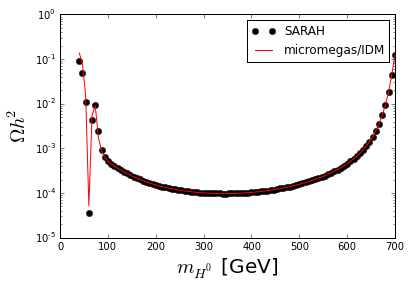

In [13]:
dfm=df[df.MH0<df.MHc]
plt.semilogy(dfm.MH0,dfm.Omega_h2,'ko',label='SARAH')
plt.semilogy(dfm.MH0,dfm.Omega_h2_official,'r-',label='micromegas/IDM')
plt.xlabel(r'$m_{H^0}$ [GeV]',size=20)
plt.ylabel(r'$\Omega h^2$',size=20)
plt.legend(loc='best')
plt.savefig('omega.pdf')

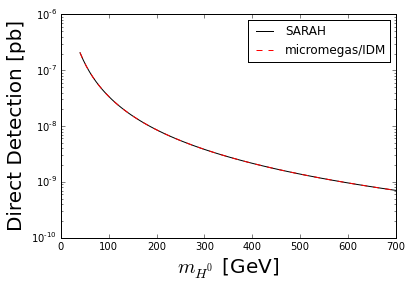

In [14]:
dfm=df[df.MH0<df.MHc]
plt.semilogy(dfm.MH0,dfm.proton_SI,'k-',label='SARAH')
plt.semilogy(dfm.MH0,dfm.proton_SI_official,'r--',label='micromegas/IDM')
plt.xlabel(r'$m_{H^0}$ [GeV]',size=20)
plt.ylabel(r'Direct Detection [pb]' ,size=20)
plt.legend(loc='best')
plt.savefig('dd.pdf')